

```
CS 7641 Assignment 1 Code - Supervised Learning
# -- name: Ahmad Moltafet
# -- GTID: 903959012
# -- Analysis Report: https://www.overleaf.com/read/kvnsqjktdgyt#bab80d
# -- Github Repo: https://github.com/amoltafet/ml1

# 2 datasets are used in this code:
# 1. Aids 15000 Classification (https://www.kaggle.com/datasets/aadarshvelu/aids-virus-infection-prediction)
# 2. Mumbai Classification (https://www.kaggle.com/datasets/prasad22/economic-census-data)

# IMPORTANT NOTE:
# YOU CAN FIND THE CODE IN THE FOLLOWING LINK WITH THE OUTPUTS:
# https://colab.research.google.com/drive/1ojecPIcS7Vd5VAoIjEc8Ihn8dnjCRYyR?usp=sharing

```



In [1]:
#### ----- 1 - Loading All Data and Preprocessing ----- ####

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')

plt.style.use('ggplot')

current_path = os.getcwd()

os.chdir(current_path)
print("Current Directory:", os.getcwd())

Current Directory: /content


In [2]:
## Load Aids Classification Dataset

df_aids = pd.read_csv('AIDS_Classification_5000.csv').astype('category')
df_aids = df_aids.head(1000)
print("Aids Data has",len(df_aids),"rows and", len(df_aids.columns),"columns.")
if df_aids.isnull().values.any():
    print("Warning: Missing Data")
#df_phish.head()
#df_phish.describe(include='all')

## Load the Mumbai Economic Census Data

df_thy = pd.read_csv('mumbai.csv')
df_thy = df_thy.head(1000)
print("Mumbai has",len(df_thy),"rows and", len(df_thy.columns),"columns.")
if df_thy.isnull().values.any():
    print("Warning: Missing Data")
#df_bank.head()
#df_bank.describe(include='all')

Aids Data has 1000 rows and 23 columns.
Mumbai has 1000 rows and 25 columns.


In [3]:
# Preprocess mumbai dataset

# Drop columns with missing values
df_thy = df_thy.dropna()

# Convert categorical features to numeric using one-hot encoding
df_thy = pd.get_dummies(df_thy)


In [4]:
# Preprossesing Aids Classification Dataset:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Numerical features
aids_numerical_features = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
# Binary features
aids_binary_features = ['hemo', 'homo', 'drugs', 'oprior', 'z30', 'symptom', 'treat', 'offtrt']
# Categorical features
aids_categorical_features = ['trt', 'race', 'gender', 'strat']

aids_numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

aids_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
aids_preprocessor = ColumnTransformer(
    transformers=[
        ('num', aids_numerical_transformer, aids_numerical_features),
        ('cat', aids_categorical_transformer, aids_categorical_features),
        ('bin', 'passthrough', aids_binary_features)
    ])

# Separate features and target
X = df_aids.drop(columns=['infected'])
y = df_aids['infected']

# Apply preprocessing
X_preprocessed = aids_preprocessor.fit_transform(X)

# Convert the preprocessed data back to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed)




In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit
import numpy as np

# Set global plot parameters
plt.rcParams.update({
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 12,
    'font.size': 12
})

def load_data(df_aids, df_thy):
    """Extracts features and labels from the given dataframes."""
    X_aids = df_aids.iloc[:, 1:-1].values.astype('int64')
    y_aids = df_aids.iloc[:, 0].values.astype('int64')
    X_thy = df_thy.iloc[:, 1:-1].values.astype('int64')
    y_thy = df_thy.iloc[:, 0].values.astype('int64')
    return X_aids, y_aids, X_thy, y_thy

def display_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Plots the learning curve for a given model."""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    #checkk color here
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

def display_learning_curves(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    """Plots the learning curves for training and cross-validation scores."""
    plt.figure()
    plt.title("Learning curve : " + title)
    plt.xlabel("Training examples")
    plt.ylabel("model F1 score")
    # possibly - 2 *
    plt.fill_between(train_sizes, train_mean - 2 * train_std, train_mean + 2 * train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2 * cv_std, cv_mean + 2 * cv_std, alpha=0.1, color="r")

    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")

    plt.legend(loc="best")
    plt.show()

def display_timing(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    """Plots the training and prediction times."""
    plt.figure()
    plt.title("Modeling Time : " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Time (s)")
    # same as above
    plt.fill_between(train_sizes, fit_mean - 2 * fit_std, fit_mean + 2 * fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, alpha=0.1, color="r")

    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (seconds)")
    plt.plot(train_sizes, pred_mean, 'o-', color="r", label="Prediction Time (seconds)")

    plt.legend(loc="best")
    plt.show()

def display_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Displays the confusion matrix."""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # .2f if
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

def evaluate_classifier(clf, X_train, X_test, y_train, y_test):
    """Evaluates a classifier with training and test data."""
    start_train = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_train = timeit.default_timer()
    training_duration = end_train - start_train

    start_pred = timeit.default_timer()
    y_pred = clf.predict(X_test)
    end_pred = timeit.default_timer()
    prediction_duration = end_pred - start_pred

    auc_score = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    # evaluation
    print("Model Evaluation Metrics Using Test Dataset")
    print("*****************************************************")
    print(f"Training Time (s):   {training_duration:.5f}")
    print(f"Prediction Time (s): {prediction_duration:.5f}\n")
    print(f"F1 Score:  {f1:.2f}")
    print(f"Accuracy:  {accuracy:.2f}     AUC: {auc_score:.2f}")
    print(f"Precision: {precision:.2f}     Recall: {recall:.2f}")
    print("*****************************************************")

    plt.figure()
    display_confusion_matrix(conf_matrix, classes=["0", "1"], title='Confusion Matrix')
    plt.show()

def display_model_complexity_curve(model, title, X, y):
    """
    Plots the model complexity curve for a given model.

    Args:
        model: The model object.
        title: The title of the plot.
        X: The input data.
        y: The target data.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.05, 1, 12)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}


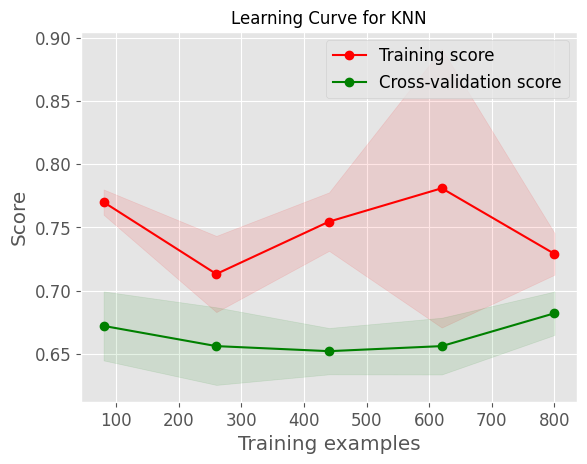

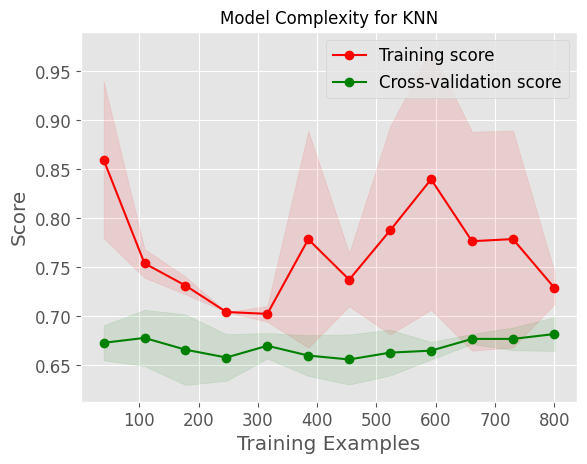

In [21]:
# KNN Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit

knn_clf = KNeighborsClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Perform hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV
grid_search_knn = GridSearchCV(knn_clf, param_grid_knn, cv=5, scoring='accuracy', return_train_score=True)
grid_search_knn.fit(X_preprocessed, y)

# display.. the best parameters
print("Best parameters for KNN:", grid_search_knn.best_params_)

# Plot the learning curve
display_learning_curve(grid_search_knn, "Learning Curve for KNN", X_preprocessed, y)

# Plot the model complexity curve
display_model_complexity_curve(grid_search_knn, "Model Complexity for KNN", X_preprocessed, y)



Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


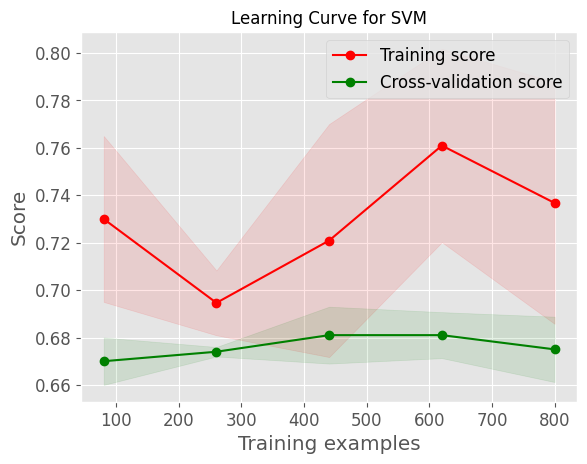

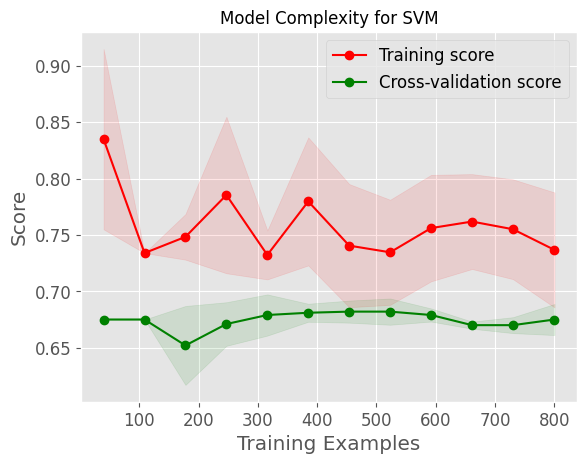

In [22]:
# Support Vector Machines.
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit


svm_clf = SVC()

# Define the parameter grid for hyperparameter tuning
param_grid_svm = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Perform hyperparameter tuning using GridSearchCV
grid_search_svm = GridSearchCV(svm_clf, param_grid_svm, cv=5, scoring='accuracy', return_train_score=True)
grid_search_svm.fit(X_preprocessed, y)

# Print the best parameters
print("Best parameters for SVM:", grid_search_svm.best_params_)

# Plot the learning curve
display_learning_curve(grid_search_svm, "Learning Curve for SVM", X_preprocessed, y)

# Plot the model complexity curve
display_model_complexity_curve(grid_search_svm, "Model Complexity for SVM", X_preprocessed, y)


In [ ]:
#  Neural Networks

import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit

nn_clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000)

#  hyperparameter tuning
param_grid_nn = {
    'hidden_layer_sizes': [(5,), (10,), (15,), (20,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive']
}
# this no go
#param_grid_nn = {
#    'hidden_layer_sizes': [(5,), (10,),(20,)],
#    'activation': ['relu', 'logistic'],
#    'solver': ['sgd', 'adam'],
#    'learning_rate': ['constant']
#}

grid_search_nn = GridSearchCV(nn_clf, param_grid_nn, cv=5, scoring='accuracy', return_train_score=True)
grid_search_nn.fit(X_preprocessed, y)

print("Best parameters for Neural Networks:", grid_search_nn.best_params_)

# error here double check
display_learning_curve(grid_search_nn, "Learning Curve for Neural Networks", X_preprocessed, y)

display_model_complexity_curve(grid_search_nn, "Model Complexity for Neural Networks", X_preprocessed, y)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

Best parameters for Neural Networks: {'activation': 'logistic', 'hidden_layer_sizes': (15,), 'learning_rate': 'adaptive', 'solver': 'adam'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

Best parameters for Boosting: {'learning_rate': 0.1, 'n_estimators': 50}


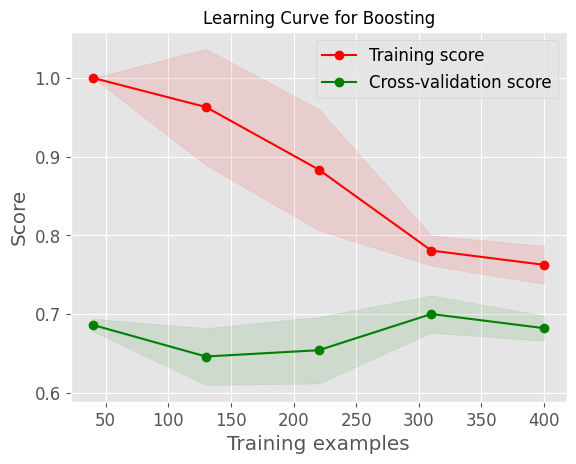

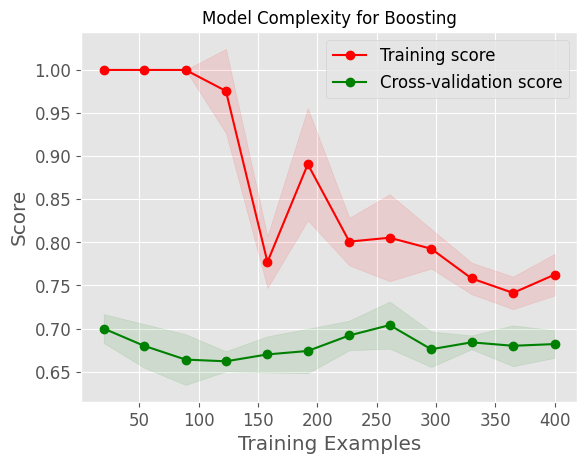

ValueError: y should be a 1d array, got an array of shape (500, 23) instead.

In [ ]:
# Boosting for Decision Trees.

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

boosting_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=500,
    learning_rate=1
)

# hyperparameter tuning
param_grid_boosting = {
    'learning_rate': [0.1, 0.5, 1, 2],
    'n_estimators': [50, 100, 200, 500]
}

grid_search_boosting = GridSearchCV(boosting_clf, param_grid_boosting, cv=5, scoring='accuracy', return_train_score=True)
grid_search_boosting.fit(X_preprocessed, y)

# he best parameters
print("Best parameters for Boosting:", grid_search_boosting.best_params_)

display_learning_curve(grid_search_boosting, "Learning Curve for Boosting", X_preprocessed, y)

display_model_complexity_curve(grid_search_boosting, "Model Complexity for Boosting", X_preprocessed, y)

best_boosting_clf = grid_search_boosting.best_estimator_
#evaluate_classifier(best_boosting_clf, X_train, X_test, y_train, y_test)

